1. Check whether decoding latent vectors that are drawn from the prior distribution yields reasonable sequences.
2. Check whether we can accurately reconstruct sequences after encoding them (i.e. encode sequence, then decode back, then check whether we get something close to what we started with)

## Preliminaries

In [19]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import pandas
import sys
from modules_gd.model import VAE
# help(VAE)
from modules_gd.data import MSA_Dataset
# help(MSA_Dataset)

In [22]:
MSA_id = "PF00565"
data_path = f"data/Ding/processed/{MSA_id}"

Load binarized MSA

In [23]:
## read multiple sequence alignment in binary representation
with open(f"{data_path}/seq_msa_binary.pkl", 'rb') as file_handle:
    msa_binary = torch.tensor(pickle.load(file_handle))
# Number of sequences
n_real_seq = msa_binary.shape[0]
# Dimensions of one-hot encoding
nl = msa_binary.shape[1]
nc = msa_binary.shape[2]
# Print shape
msa_binary.shape

torch.Size([7907, 103, 21])

Load model

In [24]:
model_path = f"saved_models/{MSA_id}/model_2024-05-06.pt"
model = VAE(nl = nl, nc = nc, dim_latent_vars=2)
model_state_dict = torch.load(model_path)
model.load_state_dict(model_state_dict)

<All keys matched successfully>

Load mapping between integers and amino acid characters

In [25]:
with open(f"{data_path}/aa_index.pkl", 'rb') as file_handle:
    aa_index = pickle.load(file_handle)
# In our integer encoding of proteins, we've encoded 3 different amino acid characters as 0: '-', '.', and 'B'
# For decoding purposes, we will decode all 0's as '.'
del aa_index['-'], aa_index['B']

# now let's create the inverse mapping
idx_to_aa_dict = {}
idx_to_aa_list = ['' for i in range(nc)]
for k, v in aa_index.items():
    idx_to_aa_dict[v] = k
    idx_to_aa_list[v] = k

# Part 1: Decoding draws from the prior

In [26]:
# draws from the prior to be decoded
# z has to be a torch.tensor with a size of (num_seqs, dim_latent_space)
num_seqs = 25
dim_latent_space = model.dim_latent_vars
z = torch.randn(num_seqs, dim_latent_space)

# decode to amino acid probabilities
with torch.no_grad():
    log_p = model.decoder(z)
    p = torch.exp(log_p)
p = p.numpy()
p.shape

(25, 103, 21)

In [27]:
# covert probablities into actual protein sequences by choosing the most likely amino acid at each position.
max_prob_idx = np.argmax(p, -1)
seqs = []
for i in range(num_seqs):
    seq = [idx_to_aa_list[idx] for idx in max_prob_idx[i,:]]
    print("".join(seq))
    seqs.append("".join(seq))

LVLSGIRAPRTARNPSKSEPFGTEAHDFVSRRLLQRDVEIEVESVDKSGGFIGTLYYNKENIALSLLKEGLATVHEYSAQSSWAKQLYAAEKEAKEARKNLWK
IRLYGVDAPESAQQCKAGYPCGLVSKDALAKKIGSSPVTCEVKNKDQYGRNVAVCYLGGEDLNAWLVSNGYAVAYRQYG.....KEYVPLEDAAKAARRGIWQ
LQLSGIKAPAVRRGGGVAEPFGEEAKFFVESRLLQRDVKVILEGVSNNQNFVGSVLHPAGNIAEFLLKEGLAKCLDWSSVTGGPEKYRAAEKIAKEKRLRLWK
FVLGGIRAPRSARNPSKGEPFGQEAHDFANRRCMQRDVEIDVEDIDKVGGFIGTLYVNRENFAKILVEEGLASVHAYSAQSGNANELFAAEKKAKEARKGLWH
VYLSSIRAPRLGNAGREEEPWAYEAKEFLRKRLIGKTVTVEVEYVDKEERTFATVTLGGQNVAELLVARGLATVIRRRNRSAYYDDLVAAETKAKKAKKGL..
..LASVDAPELEKIGSGAEPFAFESRDALRELVVGKVVQCQVLYTVNSGREVGTVLLSGPSLPEEMLKAGWVKVREAAGGLQRLDALRRLEAEAKAAGKGLWA
ISLAYIQAPRLA....PEEPYAFEARELLRKLLIGKPVKFWVDYKEAGGREFGRLSVPGEDINEYLLKNGLAKLRDKRPEDELYDALRAAESKARAAKKGLWS
IYLSNVIAPRLARRPTKDEPYAWEAREFLRKKLIGQEVTFTVEYTATSGREYGRVYLGGENVTESLVSEGLVEVRR.GRNDEYVTKLLELEDQAKAAGKGKWS
IRLAGIDTPRTDDFGNPAQPFAQEAKKFVEDKLLTTKVTVKVSIIDQYGRPIALVYVGGNNVSEKLLKNGLAEVVDWQSGSSTMSKLRKAEQTAKALGKGIW.
INLSNITAPKLARRPTKDEPYAWEAREFLRKKLIGQEVCFTVEKPPNSGREYGTVYLGGENVTE

Now let's compare to the real sequences:

In [29]:
with open(f"{data_path}/seq_msa.pkl", 'rb') as file_handle:
    msa = torch.tensor(pickle.load(file_handle))
print(msa.shape)

torch.Size([7907, 103])


In [30]:
real_seqs = []
for i in range(n_real_seq):
    seq = [idx_to_aa_list[idx] for idx in msa[i,:]]
    if i < num_seqs:
      print("".join(seq))
    real_seqs.append("".join(seq))

VMLSGVKCPSFKREADTPEPFAAEAKFFTESRLLQRDVQIIL.ESCPNQIILGTILHPNGNITELLLKEGFARCVDSMAYTQGAEKLRAAERSAKERKVRIWK
IHLSSIRPPRLEGEGTYDIPYMFEAREFLRKKLIGKKVNVTVDYIAFSERTCATVAIGGINIAEALVSKGLATVIRYRQRSSHYDELLAAEARAIKNGKGLHS
IHLSSIRPPRLEGESAYDIPYMFEAREFLRKKLIGKKVNVTVDYISFSERTCATVSIGGINIAEALISKGLSTVIRYRQRSSHYDELLAAEARAIKNGKGLHS
VNLSSIRSPKMGNPRRKPAPYAREAKEFLRTRLIGQKVSVSMEYSDSKLMDFGSVFLVGPNVGELIVSRGFGTVIRHRDRSNHYDALLAAESRANSGKKGIH.
FVLGGIRAPKSARGPNKAEPFGQEAHDLATKRLTQRDVEVDVHSIDKVGGFIGELYINKESFAKILVEEGFATVHVYSAQAGNATELLGAEQRAKDARRGLWV
VTLAATRSPRAAAITNKSEELGDVARFFTESRLLHQDVTVSLLGLTSNTPFVATVTHAQGNIAAFLLQGGLARIVDHAGGPEEMGALRRAEADAKAAKKGIWH
VMLSGIKCPTFKREADVPEPFAAEAKFFTESRLLQRDVQIV.LESCHNQNILGTILHPNGNITELLLKEGFARCVDSIAYTRGADKLRAAERFAKERKLRIWR
VKVAGVITPQTAFNPRTADPLSEEAKNFVIRLVQQREVNVQVYTSDRGGNFISAVTLKGTNLSVALVEAGFATVGNADR.LPFCQQLADAEDEARSAGLNIWA
..IAGIRTPATERTLPPAEEYGNEARSFVESRLLQRKIKVEIVGASAQGQLVATLIHPRGNIAEFLLQEGLARCNDFHSLGERMAALRAAEKQAQSKKLRL..
FSLAYVTAPRLSKDGD..EPYAFQSREFLRELTLGKPIKCTVLYTPNSGREYGIAQLQGTELPE

In [32]:
# What's the proportion of characters that match the original
correct = 0
total = 0
for (seq, real_seq) in zip(seqs, real_seqs[:num_seqs]):
  correct += sum([real_c == recon_c for (real_c, recon_c) in zip(seq, real_seq)])
  total += len(seq)
print(f"correct: {correct}")
print(f"total: {total}")
print(f"Percentage correct: {np.round(100*correct/total, 2)}")

correct: 826
total: 2575
Percentage correct: 32.08


# Part 2: Reconstructing sequences

Get some real sequences in binary format to try to reconstruct

In [42]:
# for some reason, msa_binary is float64 so first transform it to float 32
msa_binary = msa_binary.to(torch.float32)
# Let's work with just the first 5000 sequences for now
real_seqs_binary = msa_binary[:5000]

In [43]:
real = torch.argmax(real_seqs_binary, -1)

We can see that these are the same real sequences printed above by transforming from binary to integer and then to character

In [44]:
for seq in torch.argmax(real_seqs_binary, -1): #argmax works for extracting position of the 1 from the one hot encoded vectors
    char_list = [idx_to_aa_list[idx] for idx in seq]
    print("".join(char_list))
    real_seqs.append("".join(char_list))

VMLSGVKCPSFKREADTPEPFAAEAKFFTESRLLQRDVQIIL.ESCPNQIILGTILHPNGNITELLLKEGFARCVDSMAYTQGAEKLRAAERSAKERKVRIWK
IHLSSIRPPRLEGEGTYDIPYMFEAREFLRKKLIGKKVNVTVDYIAFSERTCATVAIGGINIAEALVSKGLATVIRYRQRSSHYDELLAAEARAIKNGKGLHS
IHLSSIRPPRLEGESAYDIPYMFEAREFLRKKLIGKKVNVTVDYISFSERTCATVSIGGINIAEALISKGLSTVIRYRQRSSHYDELLAAEARAIKNGKGLHS
VNLSSIRSPKMGNPRRKPAPYAREAKEFLRTRLIGQKVSVSMEYSDSKLMDFGSVFLVGPNVGELIVSRGFGTVIRHRDRSNHYDALLAAESRANSGKKGIH.
FVLGGIRAPKSARGPNKAEPFGQEAHDLATKRLTQRDVEVDVHSIDKVGGFIGELYINKESFAKILVEEGFATVHVYSAQAGNATELLGAEQRAKDARRGLWV
VTLAATRSPRAAAITNKSEELGDVARFFTESRLLHQDVTVSLLGLTSNTPFVATVTHAQGNIAAFLLQGGLARIVDHAGGPEEMGALRRAEADAKAAKKGIWH
VMLSGIKCPTFKREADVPEPFAAEAKFFTESRLLQRDVQIV.LESCHNQNILGTILHPNGNITELLLKEGFARCVDSIAYTRGADKLRAAERFAKERKLRIWR
VKVAGVITPQTAFNPRTADPLSEEAKNFVIRLVQQREVNVQVYTSDRGGNFISAVTLKGTNLSVALVEAGFATVGNADR.LPFCQQLADAEDEARSAGLNIWA
..IAGIRTPATERTLPPAEEYGNEARSFVESRLLQRKIKVEIVGASAQGQLVATLIHPRGNIAEFLLQEGLARCNDFHSLGERMAALRAAEKQAQSKKLRL..
FSLAYVTAPRLSKDGD..EPYAFQSREFLRELTLGKPIKCTVLYTPNSGREYGIAQLQGTELPE

Encode these sequences

In [45]:
with torch.no_grad():
  mu, sigma = model.encoder(real_seqs_binary)
mu.shape, sigma.shape

(torch.Size([5000, 2]), torch.Size([5000, 2]))

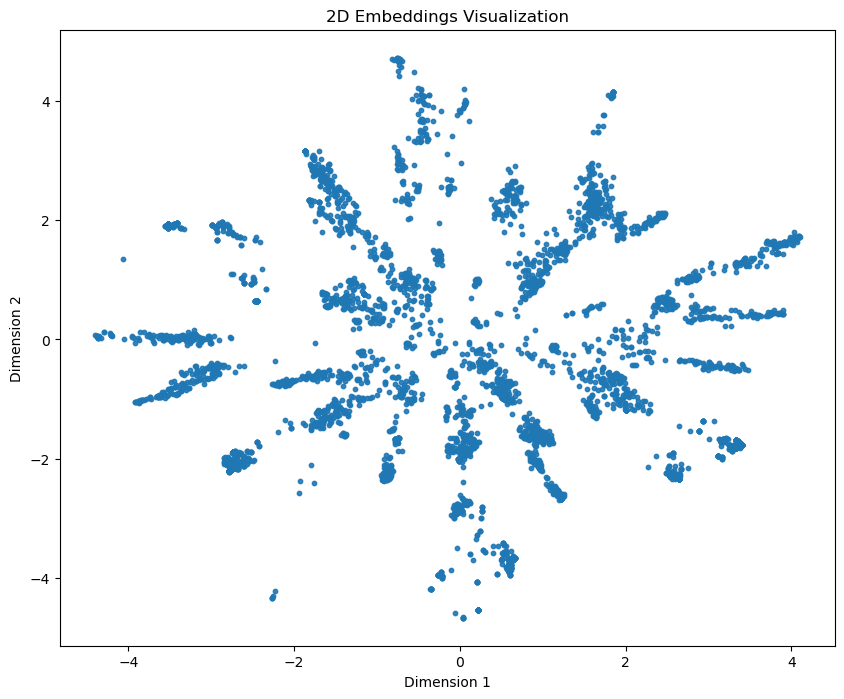

In [46]:
# Create a scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(mu[:, 0], mu[:, 1], s=10, alpha=0.9)

# Add axis labels
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

# Add a title
plt.title('2D Embeddings Visualization')

# Show the plot
plt.show()

Now we decode the $\mu$'s

In [48]:
with torch.no_grad():
  log_p = model.decoder(mu)
  p = torch.exp(log_p)
p.shape

torch.Size([5000, 103, 21])

In [49]:
# covert probablities into actual protein sequences by choosing the most likely amino acid at each position.
max_prob_idx = torch.argmax(p, -1)
seqs = []
for i in range(num_seqs):
    seq = [idx_to_aa_list[idx] for idx in max_prob_idx[i,:]]
    print("".join(seq))
    seqs.append("".join(seq))

VMLSGVKCPTFKREADTPEPFAAEAKFFTESRLLQRDVQIIL.ESCPNQIILGTILHPNGNITELLLKEGFARCVDSMAYTQGAEKLRAAERSAKERKVRIWK
IHLSSIRPPRLEGESKYDIPYMFEAREFLRKKLIGKKVNVTVDYIAFSERTCATVTIGGINIAEALVSKGLATVIRYRQRSSHYDELLAAEARAIKNGKGLHS
IHLSSIRPPRLEGESKYDIPYMFEAREFLRKKLIGKKVNVTVDYIAFSERTCATVTIGGINIAEALVSKGLATVIRYRQRSSHYDELLAAEARAIKNGKGLHS
VNLSSIRCPKMGNPRRKPAPYAREAKEFLRTRLIGKQVNVSMEYSDSRVMDFGSVFLPGVNVAELLLSRGFGTVIRHRDRSNHYDALLAAESRAISGKKGIH.
LVLGGIRAPRSARNPGKGEPFGQEAHDFANRRCMQRDVEIDVETIDKVGGFIGTLYVNRENFAKILVEEGLATVHAYSAQSGHANELFAAEKKAKEARKGLWH
LLLAGIKAPRSARPDGPAEPFGEEAKFFVESRLLQRNVKVTLLGLSPSGVFIGTVLHPAGNIAEFLLAAGLARVVDWHSGGGGMEKLRQAEKTAKEKRLGLWK
VMLSGIKCPTFRREADTPEPFAAEAKFFTESRLLQRDVQII.LESCHNQNILGTILHPNGNITELLLKEGFARCVDSIAYTRGAEKLRAAERFAKERRLRIWR
.KVAGIKCPQPARRGATAEPFGEEAKLFTRRHVQQRNVEVEVEDMDRGGNAFGPLFLGGTNFGVALLEAGLATVDNADRRTPYAQQLQRAEEKAKAAKKKYWS
..LAGIRTPATERTLPPAEEYGNEARAFVEQRLLQRQVKVEIVGASPQGQLVASVIHPRGNIAEFLLQEGLARCNDFHSLGEKMAPLRAAEKQAQGKKLRL..
LSLAYVSAPRLRREGD..EPFAFQSREFLRELVVGKVVQFTVLYTPNTGREYGTAKLQGTELPE

In [50]:
# Proportion of amino acids correctly recovered
torch.sum(real == max_prob_idx)/real.nelement()

tensor(0.7993)

In [52]:
# What's the proportion of characters that match the original
correct = 0
total = 0
for (seq, real_seq) in zip(seqs, real_seqs):
  correct += sum([real_c == recon_c for (real_c, recon_c) in zip(seq, real_seq)])
  total += len(seq)
print(f"correct: {correct}")
print(f"total: {total}")
print(f"Percentage correct: {np.round(100*correct/total, 2)}")

correct: 2044
total: 2575
Percentage correct: 79.38
